In [5]:
import patoolib # to extract the files
import pandas as pd # for data analysis and manipulation
import numpy as np # for scientific computing
import plotly.express as px # for visualization
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for visualization
from sklearn.ensemble import ExtraTreesClassifier # for feature selection

from datetime import datetime # date manipulation

In [24]:
# .rar extraction

patoolib.extract_archive("raw/cancellation_prediction.rar", outdir="raw/")

patool: Extracting raw/cancellation_prediction.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -oraw/ -- raw/cancellation_prediction.rar


In [6]:
df = pd.read_csv("raw/cancellation_prediction.csv")

In [7]:
df

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.00,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.00,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.00,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.00,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,Hotel,0,23,2017,August,35,30,2,5,2,...,0,A,0,No Deposit,394.0,NaN,0,96.14,0,0
119386,Hotel,0,102,2017,August,35,31,2,5,3,...,0,E,0,No Deposit,9.0,NaN,0,225.43,0,2
119387,Hotel,0,34,2017,August,35,31,2,5,2,...,0,D,0,No Deposit,9.0,NaN,0,157.71,0,4
119388,Hotel,0,109,2017,August,35,31,2,5,2,...,0,A,0,No Deposit,89.0,NaN,0,104.40,0,0


In [8]:
nan_df = pd.DataFrame()
values = []


for column in df.columns:
    nan_df[column] = [len(df[column].dropna())/len(df)]

nan_df = nan_df.T
    
fig = px.bar(nan_df, x=nan_df.index, y=0)
fig.show()

In [9]:
df = df.drop(["id_person_booking"], axis=1)
df = df[df["country"].notna()]
df = df[df["num_children"].notna()]

In [10]:
months_dict = dict((v,k) for k,v in zip(range(1, 13), sorted(df["month_arrival_date"].unique(), key=lambda m: datetime.strptime(m, "%B"))))
df['month_arrival_date'] = df['month_arrival_date'].map(months_dict)

df["breakfast"] = df["breakfast"]*1

rooms_dict = dict((v,k) for k,v in zip(range(len(df["reserved_room"].unique())), np.sort(df["reserved_room"].unique())))
df['reserved_room'] = df['reserved_room'].map(rooms_dict)

type_dict = dict((v,k) for k,v in zip(range(len(df["type"].unique())), np.sort(df["type"].unique())))
df['type'] = df['type'].map(type_dict)

deposit_dict = dict((v,k) for k,v in zip(range(len(df["deposit_policy"].unique())), np.sort(df["deposit_policy"].unique())))
df["deposit_policy"] = df["deposit_policy"].map(deposit_dict)

countries_dict = dict((v,k) for k,v in zip(range(len(df["country"].unique())), df["country"].unique()))
df["country"] = df["country"].map(countries_dict)

travel_agency_dict = dict((v,k) for k,v in zip(range(len(df["id_travel_agency_booking"].unique())), df["id_travel_agency_booking"].unique()))
df["id_travel_agency_booking"] = df["id_travel_agency_booking"].map(travel_agency_dict)

In [11]:
nan_df = pd.DataFrame()
values = []


for column in df.columns:
    nan_df[column] = [len(df[column].dropna())/len(df)]

nan_df = nan_df.T
    
fig = px.bar(nan_df, x=nan_df.index, y=0)
fig.show()

In [12]:
# Tendency
mean = pd.DataFrame(df.mean()).round(2).T
median = pd.DataFrame(df.median()).round(2).T

# Dispersion
std = pd.DataFrame(df.std()).round(2).T
v_max = pd.DataFrame(df.max()).round(2).T
v_min = pd.DataFrame(df.min()).round(2).T

x = lambda x: x.max() - x.min()
v_range = pd.DataFrame(df.apply(x)).T

x = lambda x: x.skew().round(2)
skew = pd.DataFrame(df.apply(x)).T

x = lambda x: x.kurt().round(2)
kurt = pd.DataFrame(df.apply(x)).T

data_description = pd.concat([mean, median, std, v_max, v_min, v_range, skew, kurt]).T.reset_index()
data_description.columns = ["column", "mean", "median", "std", "max", "min", "range", "skew", "kurt"]
data_description

,column,mean,median,std,max,min,range,skew,kurt
0,type,0.67,1.0,0.47,1.0,0.0,1.0,-0.71,-1.50
1,cancellation,0.37,0.0,0.48,1.0,0.0,1.0,0.53,-1.72
2,days_between_booking_arrival,104.31,69.0,106.90,737.0,0.0,737.0,1.34,1.69
3,year_arrival_date,2016.16,2016.0,0.71,2017.0,2015.0,2.0,-0.23,-0.99
4,month_arrival_date,6.55,7.0,3.09,12.0,1.0,11.0,-0.03,-0.99
5,week_number_arrival_date,27.17,28.0,13.59,53.0,1.0,52.0,-0.01,-0.98
6,day_of_month_arrival_date,15.80,16.0,8.78,31.0,1.0,30.0,-0.00,-1.19
7,num_weekend_nights,0.93,1.0,1.00,16.0,0.0,16.0,1.30,5.66
8,num_workweek_nights,2.50,2.0,1.90,41.0,0.0,41.0,2.70,19.98
9,num_adults,1.86,2.0,0.58,55.0,0.0,55.0,18.46,1363.91


In [13]:
data_description[(data_description["kurt"] > 3) | (data_description["kurt"] < -3)]

,column,mean,median,std,max,min,range,skew,kurt
7,num_weekend_nights,0.93,1.0,1.00,16.0,0.0,16.0,1.30,5.66
8,num_workweek_nights,2.50,2.0,1.90,41.0,0.0,41.0,2.70,19.98
9,num_adults,1.86,2.0,0.58,55.0,0.0,55.0,18.46,1363.91
10,num_children,0.10,0.0,0.40,10.0,0.0,10.0,4.11,18.61
11,num_babies,0.01,0.0,0.10,10.0,0.0,10.0,24.70,1642.85
13,country,7.44,1.0,14.77,176.0,0.0,176.0,4.29,25.62
16,repeated_guest,0.03,0.0,0.18,1.0,0.0,1.0,5.32,26.27
17,num_previous_cancellations,0.09,0.0,0.85,26.0,0.0,26.0,24.43,671.96
18,num_previous_stays,0.13,0.0,1.48,72.0,0.0,72.0,24.04,794.61
20,changes_between_booking_arrival,0.22,0.0,0.65,21.0,0.0,21.0,6.01,79.47


# Skew and Kurt (Outliers?)

- num_weekend_nights
- num_workweek_nights
- num_adults
- num_children
- num_babies
- num_previous_cancellations
- num_previous_stays
- changes_between_booking_arrival
- required_car_parking_spaces

# Feature Selection

In [149]:
y = df["cancellation"]
X = df.drop("cancellation", axis = 1)

In [150]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
# ver pra que serve os parametros
extra_tree_forest.fit(X, y)

ExtraTreesClassifier(criterion='entropy', max_features=2, n_estimators=5)

In [151]:
feature_importance = extra_tree_forest.feature_importances_

In [152]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [153]:
fig = px.bar(x=X.columns, y=feature_importance_normalized)
fig.show()

In [ ]:
cancellation_0 = df[df["type"]==0]["cancellation"].sum() / len(df[df["type"]==0])
cancellation_1 = df[df["type"]==1]["cancellation"].sum() / len(df[df["type"]==1])
cancellation = df["cancellation"].sum() / len(df)
categories = list(type_dict) + ["Total"]
fig = px.bar(x=categories, y=[cancellation_0, cancellation_1, cancellation], title="Cancellation Rate", color=categories)
fig.show()

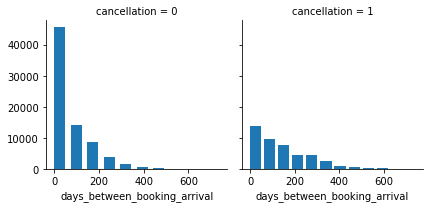

In [18]:
grid = sns.FacetGrid(df, col='cancellation')
grid.map(plt.hist, 'days_between_booking_arrival', width=50)
grid.add_legend()

In [14]:
ts_df = pd.DataFrame()
index = list()
cancellations = list()
bookings = list()

for year in np.sort(df["year_arrival_date"].unique()):
    for month in np.sort(df["month_arrival_date"].unique()):
        index.append(str(year)+"-"+str(month))
        cancellations.append(df[(df["year_arrival_date"] == year) & (df["month_arrival_date"] == month)]["cancellation"].sum())
        bookings.append(len(df[(df["year_arrival_date"] == year) & (df["month_arrival_date"] == month)]))

ts_df.index = index
ts_df["cancellations"] = cancellations
ts_df["bookings"] = bookings
ts_df.index = pd.to_datetime(ts_df.index)


In [15]:
fig = px.line(ts_df)
fig.show()

In [ ]:
# CHURN

# hipotese para item c):
# 1. A separação temporal implica que os padrões observados em determinado ano(s) sem repetiram nos próximos anos.
# 2. A separação aleatoria dá margem para que o modelo não overfite os padrões de determinados anos, se "preparando" para uma aleatoriedade futura.
# 3. Verificar resultados para certeza.
# 4. 2016 tem mais registros, combinar 2016 e outros?

# Porcentagem das colunas

# Extratreeclassifier